Importieren der notwendigen Pakete und des Trainingsdatensatzes:

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
import numpy as np
import sklearn as sk

Initialisierung des Datensatzes mit Sklearn:

Wir initialisieren uns zuerst alle Bilder mit den zugehörigen targets. Anschließend teilen wir mit der in der Aufgabenstellung angegebenen Funktion in Trainings und
Testdatensatz auf.
Nun filtern wir mit der Maske in beiden Datensätzen nach 1,5 und 7.

In [2]:
X = load_digits().images
Y = load_digits().target

TrainingI, TestI, TrainingT, TestT = sk.model_selection.train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

mask = np.isin(TrainingT, [1, 5, 7])
testmask = np.isin(TestT, [1, 5, 7])

maskI = []
maskT = []
for i in range(len(TrainingI)):
    if mask[i]:
        maskI.append(TrainingI[i])
        maskT.append(TrainingT[i])

testmaskI = []
testmaskT = []
for i in range(len(TestT)):
    if testmask[i]:
        testmaskI.append(TestI[i])
        testmaskT.append(TestT[i])

Aufgabe 1:

In diesem Absatz sind one_hot und unsere Aktivierungsfunktionen Softplus und Sigmoid mit ihren Ableitungen definiert.

Die one_hot Funktion wandelt die Targets, also die richtigen Zuordnungen unserer Bilder, in dreidimensionale Vektoren um. Dies benötigen wir, um den Abstand von der Lösung des neuronalen Netzes mit der tatsächlichen Lösung zu vergleichen.

Als Aktivierungsfunktionen, haben wir Sigmoid und Softplus implementiert. Dabei haben wir für mehr Stabilität np.log1p anstelle des normalen Logarithmus verwendet.

Wir haben ebenfalls die Ableitungen der Aktiviertungsfunktionen implementiert.


In [3]:
def one_hot(data):
    if data == 1:
        return np.array([[1],[0],[0]])
    elif data == 5:
        return np.array([[0],[1],[0]])
    elif data == 7:
        return np.array([[0],[0],[1]])

def softplus(X):
    L = np.empty((len(X), 1))
    for i in range(len(X)):
        L[i][0] = np.log1p(np.exp(X[i][0]))
    return L

def sigmoid(X):
    L = np.empty((len(X), 1))
    for i in range(len(X)):
        L[i][0] = 1 / (1 + np.exp(-X[i][0]))
    return L

def d_softplus(X):
    return sigmoid(X)

def d_sigmoid(X):
    L = np.empty((len(X), 1))
    for i in range(len(X)):
        L[i][0] = np.exp(-X[i][0]) / ((1 + np.exp(-X[i][0])) ** 2)
    return L

Loss-Funktionen und deren Ableitungen:

In [4]:
def l1(S, Y):
    N = 0
    for i in range(len(S)):
        N += (S[i][0] - Y[i][0]) ** 2
    return N

def l2(S, Y):
    N = 0
    for i in range(len(S)):
        N += Y[i][0] * np.log1p(softmax(i, S))
    return -N

def gradl1(y, f):
    return np.asarray([[2 * (f[0][0] - y[0][0]), 2 * (f[1][0] - y[1][0]), 2 * (f[2][0] - y[2][0])]])

def gradl2(y, f):
    a = softmax(0, f)
    b = softmax(1, f)
    c = softmax(2, f)
    return np.asarray([[-y[0][0] + a, -y[1][0] + b, -y[2][0] + c]])

def softmax(i, f):
    x = np.exp(f[i][0])

    b = 0
    for k in range(len(f)):
        b += np.exp(f[k][0])

    return x / b



Initialisierung von Theta:

Damit wir für unser Gradienten Abstiegsverfahren einen Startwert haben, wählen wir uns ein Theta mit zufälligen Einträgen. Diese zufälligen Einträge werden gleichverteilt aus dem Intervall zwischen -1 und 1 gewählt. Dabei hat unser zum Start gewähltes Theta selbstverständlich die selben Dimensionen wie in der Aufgabenstellung beschrieben.


Wir raten nun unser erstes Theta:

In [5]:
x = 1
y = -1
W1 = np.random.uniform(y , x, (64, 64))
b1 = np.random.uniform(y , x, (64, 1))
W2 = np.random.uniform(y , x, (32, 64))
b2 = np.random.uniform(y , x, (32, 1))
W3 = np.random.uniform(y , x, (3, 32))
b3 = np.random.uniform(y , x, (3, 1))

Theta = [W1, b1, W2, b2, W3, b3]


Aufgabe 2: Hier schreiben wir die Funktion forward und alles was wir dafür brauchen, ebenso wie eine Funktion, die
Matrizen vektorisiert. Zunächst haben wir dazu zwei Funktionen geschrieben (functionDecider und ellDecider), die
entscheiden welche der Aktivierungs - und Lossfunktionen genutzt werden sollen. Wir machen das eigentlich nur um uns zu
sparen die Funktionen mehrfach zu schreiben. Um forward zu berechnen haben wir eine Funktion geschrieben, die für
gegebenes Theta, x und Aktivierungsfunktion die Vektoren z und a berechnet. Wichtig ist dabei, dass wir uns die Werte
nach Berechnung speichern um sie nicht mehrfach neu zu berechnen. Am Ende berechnen wir die Funktion forward fast wie
auf dem Aufgabenblatt, als einzigen Unterschied wählen wir auf dem letzten Layer die Identität als Aktivierungsfunktion.

In [6]:
def vec(A):
    L = []
    for i in range(0, len(A[0])):
        for j in range(0, len(A)):
            L.append([A[j][i] / 50])
    return np.asarray(L)

def zunda(theta, x, sigma):
    z1 = np.matmul(theta[0], x) + theta[1]
    a1 = functionDecider(sigma, z1)
    z2 = np.matmul(theta[2], a1) + theta[3]
    a2 = functionDecider(sigma, z2)
    z3 = np.matmul(theta[4], a2) + theta[5]
    return [z1, a1, z2, a2, z3]

def forward(theta, x, sigma):
    return np.matmul(theta[4], functionDecider(sigma, np.matmul(theta[2], functionDecider(sigma,np.matmul(theta[0], x) +theta[1])) + theta[3])) + theta[5]

def functionDecider(func, X):
    if func == "sp":
        return softplus(X)
    if func == "spD":
        return d_softplus(X)
    if func == "sm":
        return sigmoid(X)
    if func == "smD":
        return d_sigmoid(X)

def ellDecider(func, y, f):
    if func == "l1":
        return l1(f, y)
    if func == "Dl1":
        return gradl1(y, f)
    if func == "l2":
        return l2(f, y)
    if func == "Dl2":
        return gradl2(y, f)


Aufgabe 3: Wir berechnen jetzt den Loss und den Gradienten vom Loss mittels Backpropagation.
Dies tun wir indem wir uns Hilfsfunktionen(gradb und gradW) definieren. Gradb berechnet den Gradienten von f nach b_ell abgeleitet. Die Funktion gradW berechnet den Gradienten
von der Loss-Funktion nach W_ell.
Damit Matrixmultiplikation funktioniert haben wir noch an einigen Stellen transponiert.
Die Funktion backprop berechnet die Backpropagation.
Dies tun wir indem wir zuerst die Ableitungen von f nach b_3 und nach W3 berechnen.
Der Einfachheit halber berechnen wir nun alle Ableitungen von f nach b_ell abgeleitet mit gradb.
Nun können wir die jetzt berechneten Gradienten von f skalar mit dem Gradienten nach der ersten Komponente der Loss-Funktion (Dl1 und Dl2) multiplizieren.
Dies haben wir davor nicht gemacht, da wir die Gradienten nach f gebraucht haben um die Gradienten von f nach b_ell mittels Backpropagation auszurechnen.

Nun fahren wir mit der Berechnung vom Gradienten vom Loss nach W1 und W2 fort. Dies tun wir mit der Funktion gradW.
Anschließend returnen wir unsere Liste.

Die Funktion GradLoss ist dafür zuständig über die Bilder in der Maske der Testdatensätze zu iterieren und die Gradienten der Lossfunktion nach Theta aufzusummieren.
Wir Iterieren nicht über die ganze Maske sondern nehmen uns immer 10 zufällige Bilder aus der Maske um die Laufzeit zu verbessern.


In [7]:
def gradb(l, theta, gradTf, sigma, z):

    z = functionDecider(sigma + "D", z).T
    z = np.diag(z[0])

    W = theta[2 * l].T
    b = gradTf[2 * l + 1]

    return np.matmul(np.matmul(z, W), b)

def gradW(l, gradTf, a):
    b = gradTf[2 * l - 1]
    a = a.T
    return np.matmul(b, a)

def gradTf(theta, x, y, sigma, ell):
    o = np.asarray([])
    az = zunda(theta, x, sigma)

    f = az[4]

    w3 = np.matmul(ellDecider(ell, y, f).T, az[3].T)
    b3 = np.eye(3, 3)

    L = [o, o, o, o, w3, b3]
    L[3] = gradb(2, theta, L, sigma, az[2])
    L[1] = gradb(1, theta, L, sigma, az[0])

    L[1] = np.matmul(ellDecider(ell, y, f), L[1].T).T
    L[3] = np.matmul(ellDecider(ell, y, f), L[3].T).T
    L[5] = np.matmul(ellDecider(ell, y, f), L[5].T).T

    L[2] = gradW(2, L, az[1])
    L[0] = gradW(1, L, x)

    return L

def entireLoss(theta,ell,sigma):
    sum = 0
    for i in range(len(maskI)):
        sum += ellDecider(ell[1:], one_hot(maskT[i]), forward(theta, vec(maskI[i]), sigma))
    return 1/(len(maskI)) *sum

def gradLoss(theta, sigma, ell):
    e = [np.zeros((64, 64)), np.zeros((64, 1)), np.zeros((32, 64)), np.zeros((32, 1)), np.zeros((3, 32)),
         np.zeros((3, 1))]
    sa = np.random.randint(0, len(maskI), size=10)
    for i in sa:
        l = gradTf(theta, vec(maskI[i]), one_hot(maskT[i]), sigma, ell)
        m = len(sa)
        e[0] = np.add(e[0], l[0]) / m
        e[1] = np.add(e[1], l[1]) / m
        e[2] = np.add(e[2], l[2]) / m
        e[3] = np.add(e[3], l[3]) / m
        e[4] = np.add(e[4], l[4]) / m
        e[5] = np.add(e[5], l[5]) / m
    return e

Aufgabe 4: Updaten der gelernten Parameter
Hier schreiben wir die Funktion, die das Gradientenabstiegsverfahren ausfuehrt. Wir minimieren nach theta, passen also
in jeder Iteration theta an. Das Verfahren ist im Kern so wie in der Vorlesung. Wir merken uns zusaetzlich nach dem
Verfahren welche Bilder mit dem gefundenen theta richtig bestimmt werden und welche falsch. So koennen wir am Ende die
accuracy-function plotten. Dies entspricht im Grunde dem Ergebnis nach einer Epoche. Um das zu implementieren, haben wir
die function guess geschrieben, die das bestimmte Ergebnis mit dem echten Ergebnis vegleicht. Das fuehren wir dann
einmal fuer diee Testdaten und einmal fuer die Trainingsdaten aus.

In [8]:
def graddescent(theta, a, n, sigma, ell):
    Tr = []
    Te = []
    for j in range(n):
        gL = gradLoss(theta, sigma, ell)
        theta[0] = np.add(theta[0], - a * gL[0])
        theta[1] = np.add(theta[1], - a * gL[1])
        theta[2] = np.add(theta[2], - a * gL[2])
        theta[3] = np.add(theta[3], - a * gL[3])
        theta[4] = np.add(theta[4], - a * gL[4])
        theta[5] = np.add(theta[5], - a * gL[5])

    for i in range(len(maskT)):
        t = guess(forward(theta, vec(maskI[i]), sigma), maskT[i])
        Tr.append(t)

    for i in range(len(testmaskT)):
        t = guess(forward(theta, vec(testmaskI[i]), sigma), testmaskT[i])
        Te.append(t)

    return theta, Tr, Te

def guess(f, target):
    target = one_hot(target)
    if np.argmax(target.T[0]) == np.argmax(f.T[0]):
        return 1
    return 0

def maxindex(A):
    if A[0][0] > A[1][0] and A[0][0] > A[2][0]:
        return 0
    elif A[1][0] > A[0][0] and A[1][0] > A[2][0]:
        return 1
    elif A[2][0] > A[1][0] and A[2][0] > A[0][0]:
        return 2

Aufgabe 5: Wir führen das Gradientenverfahren für jede Epoche durch und berechnen den Loss auf den Trainings- und Testdaten.

Aufgabe 6: Anschließend wird der Loss auf Trainingsdaten und Testdaten geplottet. Dafür erstellen wir "richtige" Listen mit nur 1en als Eintrag und vergleichen diese mit den Listen aus dem Gradient-Descent-Verfahren mittels der aus der Aufgabenstellung gegebenen Funktion "Accuracy-Score". Zur übersichtlichen Auswertung der Ergebnisse erstellen wir eine Konfusionsmatrix.

In [9]:
def train_full_bath(stepsize, gradIter, Epochen, sigma, ell):
    theta = Theta
    c = 0

    A = [1 for i in range(len(maskT))]
    B = [1 for i in range(len(testmaskT))]


    LTr = []
    LTe = []

    for i in range(Epochen):
        theta, Tr, Te = graddescent(theta, stepsize, gradIter, sigma, ell)
        c += 1
        print(f"\rEpoche: {c}", end="", flush=True)

        LTr.append(sk.metrics.accuracy_score(Tr, A))
        LTe.append(sk.metrics.accuracy_score(Te, B))

    plt.plot(LTr, label="Loss der Trainingsdaten", color="blue")
    plt.plot(LTe, label="Loss der Testdaten", color="red")
    plt.xlabel("Epochen")
    plt.ylabel("Accuracy-Score")
    plt.title("Loss der Trainings und Test Daten")
    plt.legend()
    plt.show()

    C_matrix = np.zeros((3, 3))

    for i in range(len(testmaskI)):

        guess = maxindex(forward(theta, vec(testmaskI[i]), sigma))
        actual = maxindex(one_hot(testmaskT[i]))

        C_matrix[actual][guess] += 1
    print()
    print("Confusion-Matrix:")
    return C_matrix

Sigmoid und euklidische Norm:

Epoche: 100

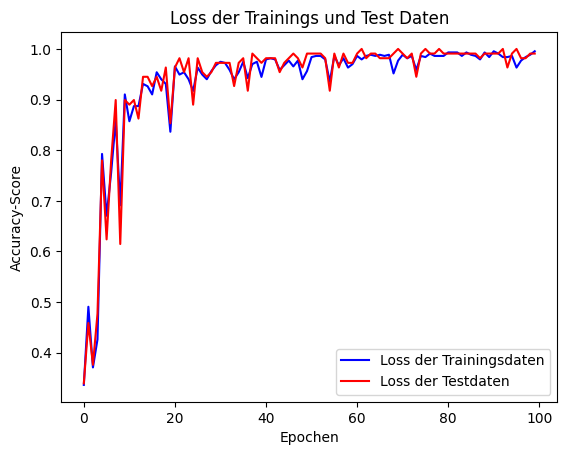


Confusion-Matrix:
[[35.  1.  0.]
 [ 0. 37.  0.]
 [ 0.  0. 36.]]


In [14]:
x = 1
y = -1
W1 = np.random.uniform(y , x, (64, 64))
b1 = np.random.uniform(y , x, (64, 1))
W2 = np.random.uniform(y , x, (32, 64))
b2 = np.random.uniform(y , x, (32, 1))
W3 = np.random.uniform(y , x, (3, 32))
b3 = np.random.uniform(y , x, (3, 1))

Theta = [W1, b1, W2, b2, W3, b3]
print(train_full_bath(0.1, 60, 100, "sm", "Dl1"))


Softplus und euklidische Norm:

Epoche: 100

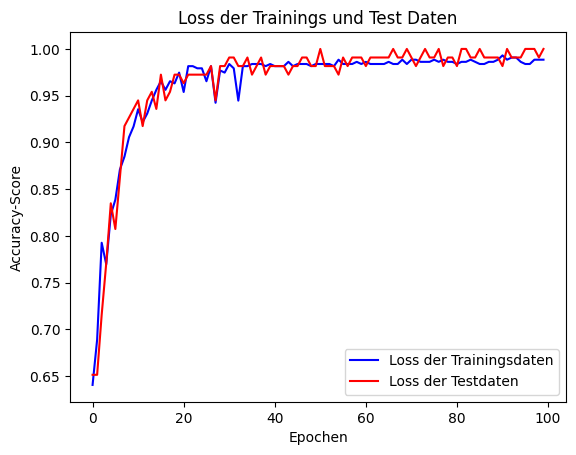


Confusion-Matrix:
[[36.  0.  0.]
 [ 0. 37.  0.]
 [ 0.  0. 36.]]


In [16]:
x = 1
y = -1
W1 = np.random.uniform(y , x, (64, 64))
b1 = np.random.uniform(y , x, (64, 1))
W2 = np.random.uniform(y , x, (32, 64))
b2 = np.random.uniform(y , x, (32, 1))
W3 = np.random.uniform(y , x, (3, 32))
b3 = np.random.uniform(y , x, (3, 1))

Theta = [W1, b1, W2, b2, W3, b3]
print(train_full_bath(0.05, 80, 100,"sp", "Dl1"))

Sigmoid und log-Entropie:

Epoche: 100

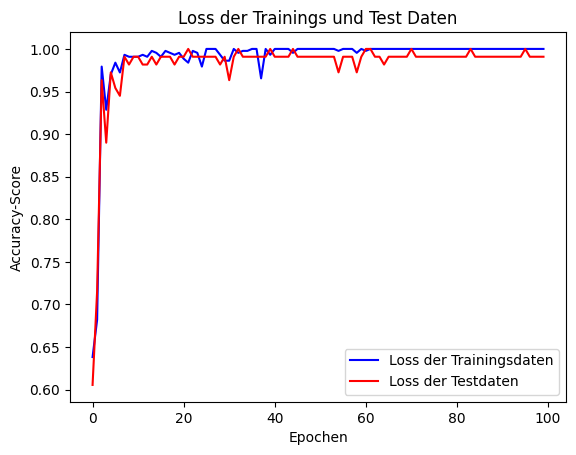


Confusion-Matrix:
[[35.  1.  0.]
 [ 0. 37.  0.]
 [ 0.  0. 36.]]


In [18]:
x = 1
y = -1
W1 = np.random.uniform(y , x, (64, 64))
b1 = np.random.uniform(y , x, (64, 1))
W2 = np.random.uniform(y , x, (32, 64))
b2 = np.random.uniform(y , x, (32, 1))
W3 = np.random.uniform(y , x, (3, 32))
b3 = np.random.uniform(y , x, (3, 1))

Theta = [W1, b1, W2, b2, W3, b3]
print(train_full_bath(0.95, 80, 100,"sm", "Dl2"))

Softplus und log-Entropie:

Epoche: 100

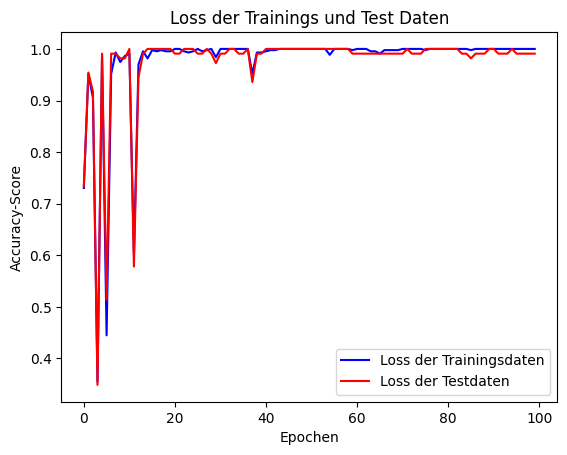


Confusion-Matrix:
[[35.  1.  0.]
 [ 0. 37.  0.]
 [ 0.  0. 36.]]


In [22]:
x = 1
y = -1
W1 = np.random.uniform(y , x, (64, 64))
b1 = np.random.uniform(y , x, (64, 1))
W2 = np.random.uniform(y , x, (32, 64))
b2 = np.random.uniform(y , x, (32, 1))
W3 = np.random.uniform(y , x, (3, 32))
b3 = np.random.uniform(y , x, (3, 1))

Theta = [W1, b1, W2, b2, W3, b3]

print(train_full_bath(0.5, 40, 100,"sp", "Dl2"))